In [0]:
cd /content/drive/My Drive/FireFriday

/content/drive/My Drive/FireFriday


In [0]:
ls

FireKeras.ipynb       sample_submission.csv  train_df.csv
FirePytorch.ipynb     test_df.csv            train_df.csv.zip
kaggle.json           test_df.csv.zip
radam_submission.csv  torch_submission.csv


In [0]:
%matplotlib inline
from keras.models import Sequential, load_model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint,History,EarlyStopping,LearningRateScheduler
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, Adadelta, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sample_submission = pd.read_csv("sample_submission.csv")
data = pd.read_csv("train_df.csv")
test_data = pd.read_csv("test_df.csv")
        

Using TensorFlow backend.


#데이터 나누기

In [0]:
train = data[:]
val = data[37000:]
train_label = np.float32(train.label)
val_label = np.float32(val.label)
train_image = np.float32(train[train.columns[1:]])
val_image = np.float32(val[val.columns[1:]])
test_image = np.float32(test_data[test_data.columns[1:]])
print('train shape: %s'%str(train.shape))
print('val shape: %s'%str(val.shape))
print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))
print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))
print('test_image shape: %s'%str(test_image.shape))

train shape: (42000, 785)
val shape: (5000, 785)
train_label shape: (42000,)
val_label shape: (5000,)
train_image shape: (42000, 784)
val_image shape: (5000, 784)
test_image shape: (18000, 784)


# One-hot encode 만들기

In [0]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 10,
    horizontal_flip = False,
    zoom_range = 0.15)

# one-hot coding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False,categories='auto')
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
# transform
train_label = train_label.reshape(-1,1)
val_label = val_label.reshape(-1,1)

train_label = encoder.transform(train_label)
val_label = encoder.transform(val_label)

print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))

train_label shape: (42000, 10)
val_label shape: (5000, 10)


#Image 변환

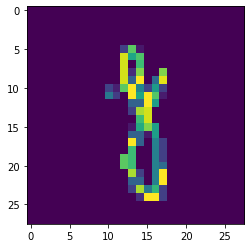

(784,)
train_image shape: (42000, 28, 28, 1)
train_image shape: (42000, 28, 28, 1)
val_image shape: (5000, 28, 28, 1)


In [0]:
plt.imshow(train_image[13].reshape(28,28))
plt.show()
print(train_image[13].shape)

train_image = train_image/255.0
val_image = val_image/255.0
test_image = test_image/255.0

train_image = train_image.reshape(train_image.shape[0],28,28,1)
val_image = val_image.reshape(val_image.shape[0],28,28,1)
test_image = test_image.reshape(test_image.shape[0],28,28,1)
print('train_image shape: %s'%str(train_image.shape))

print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))

#모델 만들기

In [0]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256,kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(Dropout(0.3))
model.add(Dense(256,kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(Dropout(0.3))
model.add(Dense(512,kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0   

In [0]:
BATCH_SIZE = 512
EPOCHS = 60

#Training

In [0]:
model.compile(loss='categorical_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])
# fit data
datagen.fit(train_image)

# training
history = model.fit_generator(datagen.flow(train_image,train_label, batch_size=BATCH_SIZE),
                              epochs = EPOCHS,
                              shuffle=True,
                              validation_data = (val_image,val_label),
                              verbose = 1,
                              steps_per_epoch=train_image.shape[0] // BATCH_SIZE)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
82/82 [==============================] - 38s 457ms/step - loss: 6.7414 - acc: 0.6573 - val_loss: 0.9107 - val_acc: 0.9678
Epoch 2/60
82/82 [==============================] - 26s 319ms/step - loss: 0.4471 - acc: 0.9570 - val_loss: 0.1623 - val_acc: 0.9912
Epoch 3/60
82/82 [==============================] - 26s 317ms/step - loss: 0.2100 - acc: 0.9691 - val_loss: 0.1131 - val_acc: 0.9928
Epoch 4/60
82/82 [==============================] - 26s 316ms/step - loss: 0.1481 - acc: 0.9800 - val_loss: 0.0697 - val_acc: 0.9942
Epoch 5/60
82/82 [==============================] - 26s 317ms/step - loss: 0.1282 - acc: 0.9821 - val_loss: 0.0728 - val_acc: 0.9918
Epoch 6/60
82/82 [==============================] - 26s 318ms/step - loss: 0.1242 - acc: 0.9813 - val_loss: 0.0656 - val_acc: 0.9938
Epoch 7/60
82/82 [==============================] - 26s 319ms/step - loss: 0.1197 - acc: 0.9815 - val_lo

#예측

In [0]:
test_label = model.predict(test_image)
label_hot = model.predict(test_image)
label = np.argmax(label_hot,1)
id_ = np.arange(0,label.shape[0])
save = pd.DataFrame({'id':id_,'Category':label})
print(save.head(10))

In [0]:
sample_submission = pd.read_csv("sample_submission.csv") #데이터 불러오기

sample_submission['Category'] = save['Category'] #대입하고 제출
sample_submission.to_csv("/content/drive/My Drive/colab_workspace/submission_keras.csv",index=False)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8
